# On particle filters applied to electricity load forecasting : 3pm (15:00) model

In [29]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage
import math
import time
import pickle
from datetime import date

In [30]:
%load_ext autoreload
%autoreload 2
#from elec_forecast.bootstrap_filter_model import BootstrapFilterModel
from elec_forecast.rm_estimation import RmEstimation
from elec_forecast.particle_filter import ParticleFilter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load temperatures data 2015-2016

In [31]:
df_temp=pd.read_csv('data/temp_1516.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,hour,t
0,2015-01-01,00:00,5.057414
1,2015-01-01,03:00,4.609138
2,2015-01-01,06:00,4.729828
3,2015-01-01,09:00,6.052241
4,2015-01-01,12:00,9.347069


In [32]:
#temperatures every day at 3pm
hour = "15:00"
temp_day = df_temp[df_temp.hour == hour]
#temp_day.head()
#Array vector of temperatures for each day of the year
T_h=list(temp_day.t)

### Load electricity data

In [33]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df=df.drop(["daytype"+str(i) for i in range(0,9)],axis=1)
df=df.drop(df.columns[0],axis=1)
df.index=range(0,len(df))
df=df.sort_values(by=['Date'])
df['Date - Heure']=pd.to_datetime(df['Date - Heure'])
df.sort_values(by=["Date - Heure"])
#truncate to the data from 2015
df=df[(df.Date >='2015-01-01')]
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype
166957,2015-01-01 03:30:00,2015-01-01,04:30,64838,DÃ©finitive,6
153294,2015-01-01 18:30:00,2015-01-01,19:30,72562,DÃ©finitive,6
153293,2015-01-01 18:00:00,2015-01-01,19:00,71766,DÃ©finitive,6
152017,2015-01-01 01:00:00,2015-01-01,02:00,71134,DÃ©finitive,6
152018,2015-01-01 04:30:00,2015-01-01,05:30,64379,DÃ©finitive,6


### Set variables of electricity demand

In [6]:
df['Consommation']=df['Consommation (MW)']   #leave it in MW
#For prediction, every day at 3pm
consumption_day_ahead = list(df[df['Heure'] == hour]['Consommation'])

### Daytype

In [7]:
daytype=np.array(df[df['Heure']==hour]['daytype'])

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option C: MCMC using MHA or Gibbs (TBA)

#### Freeze parameters from Zak's simulation in gibbs-parameters_init_v1

### Parameters

In [34]:
M=10**3 #number of particles
n_pred=365  #number of predictions

In [35]:
N_daytype=9
#k_day=npr.dirichlet(np.ones(N_daytype),1)
len_init=15
pred_forward=[0]

In [36]:
#Load pickle file
output_file ='data/parameters_init_20180113-135329.pkl'
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init

{'g_heat_init': array([-814623.94530988,   -1103.5042025 ,  -13509.35223552,
         -12839.18874712,  -13810.69394068,  -13621.95767042,
         -16305.45122647,  -16251.90232773,  -16229.3696953 ,
         -17229.49394215,  -13669.17597616,  -15726.25635544,
         -14808.97478176,  -14519.69267177,  -13655.86349596,
         -13546.63330023,  -13762.6351832 ,  -16223.92473751,
         -16231.78960435,  -17198.22294889,  -16084.04185055,
         -14859.33888566,  -15086.97652322,  -15659.32736924,
         -15025.21396291,  -16876.95500528,  -18016.91503558,
         -14386.93382501,  -14456.1228341 ,  -17258.13559834,
         -16399.27181928,  -14184.38234493,  -17037.65684651,
         -17577.66776037,  -15905.47860891,  -14955.89959227,
         -16811.49451007,  -15179.88058645,  -16273.87576028,
         -16666.00910714,  -16425.26301396,  -17107.27359641,
         -17374.00623292,  -13665.90412278,  -16588.1106145 ,
         -16457.00065552,  -16112.43401709,  -15547.969

In [37]:
s_init=parameters_init['s_init']
g_heat_init=parameters_init['g_heat_init']
sigma_s_init=parameters_init['sigma_s_init']
sigma_g_init=parameters_init['sigma_g_init']
x_init=parameters_init['x_init']
sigma2=parameters_init['sigma2']
u_h=parameters_init['u_h']
kappa=parameters_init['kappa']
w_init=parameters_init['w_init']

In [89]:
sigma2=np.ones(M)*3*10**7
sigma_g_init=np.ones(M)*np.sqrt(127000000)
sigma_s_init=np.ones(M)*np.sqrt(10**8)
kappa=np.ones(M)

In [90]:
w_init[0]=np.median(w_init)
x_init[0]=np.median(x_init)
g_heat_init[0]=np.median(g_heat_init)
s_init[0]=np.median(s_init)

### Part 2: regularize weights and x if necessary

In [91]:
pf = ParticleFilter(consumption_day_ahead, 
                    T_h, 
                    daytype, 
                    n_pred, 
                    M, 
                    x_init, 
                    w_init,
                    kappa,
                    u_h, 
                    sigma_s_init, 
                    sigma_g_init, 
                    s_init, 
                    g_heat_init, 
                    sigma2)

ESS of normalized weights= 862.234293
ESS>=0.5*M
new ESS= 862.234293


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

n= 1
s_prev 4.45e+03
sigma_s_prev 1.00e+04
nu: 3.12e+03
sigma_s: 1.31e+04
err: 9.24e+03
x_pred_mean = 5.28e+04 real consumption= 6.86e+04
x_pred min= 2.31e+03 x_pred max 6.78e+05
ESS of normalized weights= 183.254336
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 2
s_prev 1.37e+04
sigma_s_prev 1.31e+04
nu: 2.33e+03
sigma_s: 1.55e+04
err: 7.49e+03
x_pred_mean = 8.27e+04 real consumption= 6.41e+04
x_pred min= 3.42e+03 x_pred max 6.75e+05
ESS of normalized weights= 176.010799
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 3
s_prev 2.12e+04
sigma_s_prev 1.55e+04
nu: 2.20e+03
sigma_s: 1.76e+04
err: 6.46e+03
x_pred_mean = 1.26e+05 real consumption= 5.74e+04
x_pred min= 1.60e+03 x_pred max 6.86e+05
ESS of normalized weights= 118.755794
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 4
s_prev 2.76e+04
sigma_s_prev 1.76e+04
nu: 2.83e+03
sigma_s: 2.05e+04
err: 7.39e+03
x_pred_mean = 1.66e+05 real consumption= 7.31e+04
x

new ESS= 1000.0
------------------------
n= 30
s_prev 1.77e+05
sigma_s_prev 4.79e+04
nu: 6.30e+02
sigma_s: 4.85e+04
err: 6.14e+03
x_pred_mean = 3.07e+05 real consumption= 6.84e+04
x_pred min= 1.91e+04 x_pred max 2.20e+06
ESS of normalized weights= 23.202076
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 31
s_prev 1.84e+05
sigma_s_prev 4.85e+04
nu: 3.37e+02
sigma_s: 4.88e+04
err: 7.72e+03
x_pred_mean = 3.73e+05 real consumption= 6.67e+04
x_pred min= 1.71e+04 x_pred max 2.66e+06
ESS of normalized weights= 13.473635
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 32
s_prev 1.91e+05
sigma_s_prev 4.88e+04
nu: 8.06e+02
sigma_s: 4.96e+04
err: 6.31e+03
x_pred_mean = 3.35e+05 real consumption= 7.71e+04
x_pred min= 1.25e+04 x_pred max 2.51e+06
ESS of normalized weights= 23.973051
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 33
s_prev 1.98e+05
sigma_s_prev 4.96e+04
nu: 9.18e+02
sigma_s: 5.06e+04
err: 3.13e+03
x_pred_me

new ESS= 1000.0
------------------------
n= 60
s_prev 3.49e+05
sigma_s_prev 6.56e+04
nu: 4.53e+02
sigma_s: 6.60e+04
err: 6.60e+03
No heating effect
x_pred_mean = 3.56e+05 real consumption= 6.53e+04
x_pred min= 1.93e+02 x_pred max 3.78e+06
ESS of normalized weights= 43.378973
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 61
s_prev 3.56e+05
sigma_s_prev 6.60e+04
nu: 1.01e+02
sigma_s: 6.61e+04
err: 3.20e+03
No heating effect
x_pred_mean = 3.59e+05 real consumption= 6.47e+04
x_pred min= 7.55e+02 x_pred max 4.05e+06
ESS of normalized weights= 38.534724
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 62
s_prev 3.59e+05
sigma_s_prev 6.61e+04
nu: 4.21e+02
sigma_s: 6.65e+04
err: 4.23e+03
No heating effect
x_pred_mean = 3.63e+05 real consumption= 6.74e+04
x_pred min= 3.00e+02 x_pred max 3.96e+06
ESS of normalized weights= 31.816393
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 63
s_prev 3.63e+05
sigma_s_prev 6.65e+04


new ESS= 1000.0
------------------------
n= 92
s_prev 4.83e+05
sigma_s_prev 7.79e+04
nu: 3.80e+02
sigma_s: 7.83e+04
err: 4.27e+03
No heating effect
x_pred_mean = 4.88e+05 real consumption= 6.11e+04
x_pred min= 1.34e+03 x_pred max 4.48e+06
ESS of normalized weights= 30.30949
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 93
s_prev 4.88e+05
sigma_s_prev 7.83e+04
nu: 8.32e+02
sigma_s: 7.91e+04
err: 1.12e+04
No heating effect
x_pred_mean = 4.99e+05 real consumption= 5.54e+04
x_pred min= 1.67e+03 x_pred max 4.92e+06
ESS of normalized weights= 26.269279
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 94
s_prev 4.99e+05
sigma_s_prev 7.91e+04
nu: 2.51e+02
sigma_s: 7.94e+04
err: 4.95e+03
No heating effect
x_pred_mean = 5.04e+05 real consumption= 4.91e+04
x_pred min= 2.35e+03 x_pred max 4.89e+06
ESS of normalized weights= 20.655794
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 95
s_prev 5.04e+05
sigma_s_prev 7.94e+04
n

x_pred min= 2.30e+03 x_pred max 5.22e+06
ESS of normalized weights= 18.241111
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 121
s_prev 6.33e+05
sigma_s_prev 8.77e+04
nu: 2.68e+02
sigma_s: 8.80e+04
err: 5.59e+03
No heating effect
x_pred_mean = 6.38e+05 real consumption= 4.68e+04
x_pred min= 6.55e+02 x_pred max 5.17e+06
ESS of normalized weights= 16.571559
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 122
s_prev 6.38e+05
sigma_s_prev 8.80e+04
nu: 3.99e+02
sigma_s: 8.84e+04
err: 4.27e+03
No heating effect
x_pred_mean = 6.42e+05 real consumption= 4.28e+04
x_pred min= 2.75e+02 x_pred max 4.90e+06
ESS of normalized weights= 23.900458
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 123
s_prev 6.42e+05
sigma_s_prev 8.84e+04
nu: 1.16e+03
sigma_s: 8.96e+04
err: 5.32e+03
No heating effect
x_pred_mean = 6.48e+05 real consumption= 5.29e+04
x_pred min= 4.33e+02 x_pred max 4.65e+06
ESS of normalized weights= 23.863699
ESS>

new ESS= 1000.0
------------------------
n= 150
s_prev 7.85e+05
sigma_s_prev 9.79e+04
nu: 2.35e+02
sigma_s: 9.82e+04
err: 8.93e+03
No heating effect
x_pred_mean = 7.94e+05 real consumption= 4.00e+04
x_pred min= 3.54e+03 x_pred max 7.05e+06
ESS of normalized weights= 8.587661
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 151
s_prev 7.94e+05
sigma_s_prev 9.82e+04
nu: 3.07e+02
sigma_s: 9.85e+04
err: 6.62e+03
No heating effect
x_pred_mean = 8.01e+05 real consumption= 5.20e+04
x_pred min= 3.78e+03 x_pred max 7.23e+06
ESS of normalized weights= 11.101133
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 152
s_prev 8.01e+05
sigma_s_prev 9.85e+04
nu: 2.02e+02
sigma_s: 9.87e+04
err: 4.62e+03
No heating effect
x_pred_mean = 8.05e+05 real consumption= 5.31e+04
x_pred min= 1.22e+03 x_pred max 7.41e+06
ESS of normalized weights= 11.903883
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 153
s_prev 8.05e+05
sigma_s_prev 9.87e+

new ESS= 1000.0
------------------------
n= 178
s_prev 9.07e+05
sigma_s_prev 1.06e+05
nu: -1.61e+02
sigma_s: 1.06e+05
err: 4.28e+03
No heating effect
x_pred_mean = 9.11e+05 real consumption= 4.11e+04
x_pred min= 5.32e+03 x_pred max 5.98e+06
ESS of normalized weights= 7.535891
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 179
s_prev 9.11e+05
sigma_s_prev 1.06e+05
nu: 6.83e+01
sigma_s: 1.06e+05
err: 3.43e+03
No heating effect
x_pred_mean = 9.15e+05 real consumption= 5.50e+04
x_pred min= 6.85e+02 x_pred max 6.20e+06
ESS of normalized weights= 11.295449
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 180
s_prev 9.15e+05
sigma_s_prev 1.06e+05
nu: 2.98e+02
sigma_s: 1.07e+05
err: 6.67e+02
No heating effect
x_pred_mean = 9.15e+05 real consumption= 5.66e+04
x_pred min= 1.59e+03 x_pred max 6.49e+06
ESS of normalized weights= 14.916526
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 181
s_prev 9.15e+05
sigma_s_prev 1.07e

n= 205
s_prev 1.07e+06
sigma_s_prev 1.13e+05
nu: 8.11e+02
sigma_s: 1.14e+05
err: 2.55e+03
No heating effect
x_pred_mean = 1.07e+06 real consumption= 4.42e+04
x_pred min= 4.69e+03 x_pred max 7.36e+06
ESS of normalized weights= 12.427827
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 206
s_prev 1.07e+06
sigma_s_prev 1.14e+05
nu: 1.94e+02
sigma_s: 1.14e+05
err: 7.89e+03
No heating effect
x_pred_mean = 1.08e+06 real consumption= 4.01e+04
x_pred min= 1.38e+03 x_pred max 7.56e+06
ESS of normalized weights= 12.675572
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 207
s_prev 1.08e+06
sigma_s_prev 1.14e+05
nu: 5.20e+01
sigma_s: 1.14e+05
err: 2.41e+03
No heating effect
x_pred_mean = 1.08e+06 real consumption= 5.12e+04
x_pred min= 1.24e+03 x_pred max 7.77e+06
ESS of normalized weights= 17.014504
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 208
s_prev 1.08e+06
sigma_s_prev 1.14e+05
nu: 2.42e+02
sigma_s: 1.14e+05
err: 1

new ESS= 1000.0
------------------------
n= 234
s_prev 1.21e+06
sigma_s_prev 1.21e+05
nu: -1.13e+02
sigma_s: 1.21e+05
err: 9.20e+02
No heating effect
x_pred_mean = 1.21e+06 real consumption= 3.84e+04
x_pred min= 4.09e+02 x_pred max 7.62e+06
ESS of normalized weights= 8.226974
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 235
s_prev 1.21e+06
sigma_s_prev 1.21e+05
nu: 1.99e+02
sigma_s: 1.22e+05
err: 8.07e+03
No heating effect
x_pred_mean = 1.22e+06 real consumption= 4.96e+04
x_pred min= 2.71e+03 x_pred max 7.71e+06
ESS of normalized weights= 8.286347
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 236
s_prev 1.22e+06
sigma_s_prev 1.22e+05
nu: 2.02e+01
sigma_s: 1.22e+05
err: 7.90e+03
No heating effect
x_pred_mean = 1.23e+06 real consumption= 5.01e+04
x_pred min= 9.79e+02 x_pred max 7.95e+06
ESS of normalized weights= 2.524927
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 237
s_prev 1.23e+06
sigma_s_prev 1.22e+0

new ESS= 1000.0
------------------------
n= 264
s_prev 1.37e+06
sigma_s_prev 1.29e+05
nu: 4.78e+02
sigma_s: 1.29e+05
err: 5.96e+03
No heating effect
x_pred_mean = 1.38e+06 real consumption= 5.29e+04
x_pred min= 2.21e+03 x_pred max 1.14e+07
ESS of normalized weights= 11.313323
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 265
s_prev 1.38e+06
sigma_s_prev 1.29e+05
nu: 3.11e+02
sigma_s: 1.30e+05
err: 8.54e+03
No heating effect
x_pred_mean = 1.39e+06 real consumption= 5.27e+04
x_pred min= 4.35e+03 x_pred max 1.14e+07
ESS of normalized weights= 8.221521
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 266
s_prev 1.39e+06
sigma_s_prev 1.30e+05
nu: 2.15e+02
sigma_s: 1.30e+05
err: 6.73e+03
No heating effect
x_pred_mean = 1.39e+06 real consumption= 5.28e+04
x_pred min= 3.33e+03 x_pred max 1.14e+07
ESS of normalized weights= 10.229827
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 267
s_prev 1.39e+06
sigma_s_prev 1.30e+

new ESS= 1000.0
------------------------
n= 294
s_prev 1.53e+06
sigma_s_prev 1.38e+05
nu: 7.29e+02
sigma_s: 1.39e+05
err: -1.62e+03
No heating effect
x_pred_mean = 1.53e+06 real consumption= 6.07e+04
x_pred min= 1.01e+03 x_pred max 1.16e+07
ESS of normalized weights= 6.678283
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 295
s_prev 1.53e+06
sigma_s_prev 1.39e+05
nu: 6.55e+01
sigma_s: 1.39e+05
err: 9.14e+03
No heating effect
x_pred_mean = 1.54e+06 real consumption= 5.75e+04
x_pred min= 9.58e+02 x_pred max 1.14e+07
ESS of normalized weights= 3.632822
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 296
s_prev 1.54e+06
sigma_s_prev 1.39e+05
nu: 7.18e+01
sigma_s: 1.39e+05
err: 4.40e+03
No heating effect
x_pred_mean = 1.54e+06 real consumption= 4.92e+04
x_pred min= 2.97e+03 x_pred max 1.16e+07
ESS of normalized weights= 7.404969
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 297
s_prev 1.54e+06
sigma_s_prev 1.39e+0

new ESS= 1000.0
------------------------
n= 323
s_prev 1.66e+06
sigma_s_prev 1.43e+05
nu: 9.41e+02
sigma_s: 1.44e+05
err: -1.89e+03
x_pred_mean = 3.57e+06 real consumption= 5.99e+04
x_pred min= 6.05e+04 x_pred max 1.69e+07
ESS of normalized weights= 1.000057
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 324
s_prev 1.66e+06
sigma_s_prev 1.44e+05
nu: 1.77e+02
sigma_s: 1.44e+05
err: 6.07e+03
No heating effect
x_pred_mean = 1.67e+06 real consumption= 5.78e+04
x_pred min= 3.84e+03 x_pred max 1.30e+07
ESS of normalized weights= 5.883866
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 325
s_prev 1.67e+06
sigma_s_prev 1.44e+05
nu: 3.19e+02
sigma_s: 1.44e+05
err: 4.94e+02
No heating effect
x_pred_mean = 1.67e+06 real consumption= 5.51e+04
x_pred min= 2.98e+03 x_pred max 1.25e+07
ESS of normalized weights= 9.748255
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 326
s_prev 1.67e+06
sigma_s_prev 1.44e+05
nu: 6.05e+02
sig

new ESS= 1000.0
------------------------
n= 351
s_prev 1.75e+06
sigma_s_prev 1.51e+05
nu: 5.13e+01
sigma_s: 1.51e+05
err: -2.48e+03
x_pred_mean = 4.65e+06 real consumption= 6.01e+04
x_pred min= 2.97e+05 x_pred max 2.01e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 352
s_prev 1.75e+06
sigma_s_prev 1.51e+05
nu: 2.88e+00
sigma_s: 1.51e+05
err: 3.80e+03
x_pred_mean = 6.24e+06 real consumption= 5.26e+04
x_pred min= 3.35e+05 x_pred max 3.10e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 353
s_prev 1.75e+06
sigma_s_prev 1.51e+05
nu: -7.08e+01
sigma_s: 1.51e+05
err: 4.52e+03
x_pred_mean = 4.40e+06 real consumption= 5.06e+04
x_pred min= 1.58e+05 x_pred max 1.91e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 354
s_prev 1.75e+06
sigma_s_prev 1.51e+05
nu: 1.96e+02
sigma_s: 1.52e+05
err: 4.06e+03
x_pred_mean = 7.51e+06 real consumption= 

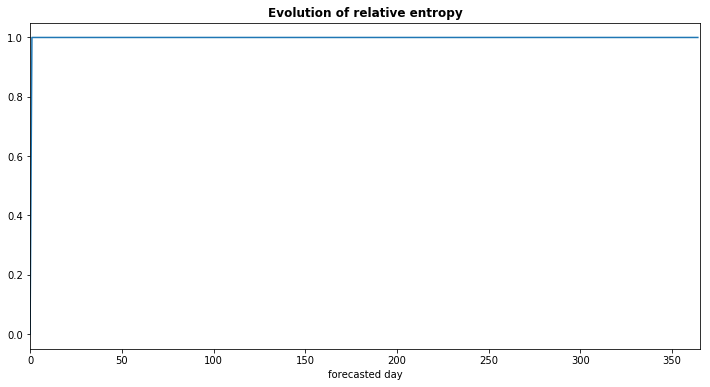

--- 17.143928050994873 seconds ---


In [101]:
start_time = time.time()
x_predict, ESS_calc = pf.predict(pred_forward, n_pred, len_init)
print("--- %s seconds ---" % (time.time() - start_time))

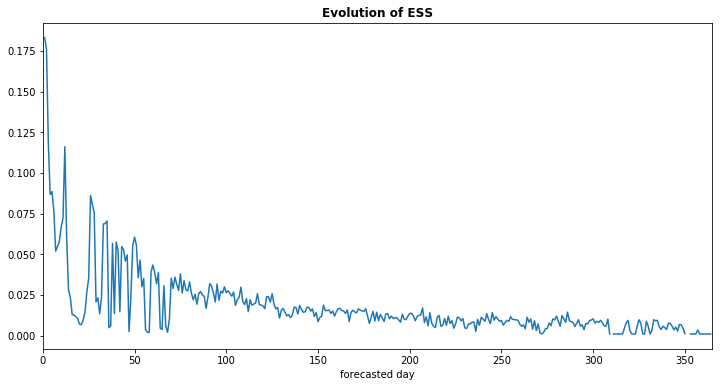

In [102]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(1,n_pred),ESS_calc[0,1:n_pred]/M)
#plt.plot(range(1,n_pred),ESS_calc[1,1:n_pred]/M)
#plt.plot(range(1,n_pred),ESS_calc[2,1:n_pred]/M)

plt.title("Evolution of ESS",fontweight='bold')
plt.xlabel('forecasted day')
plt.xlim(0,n_pred)
plt.show()

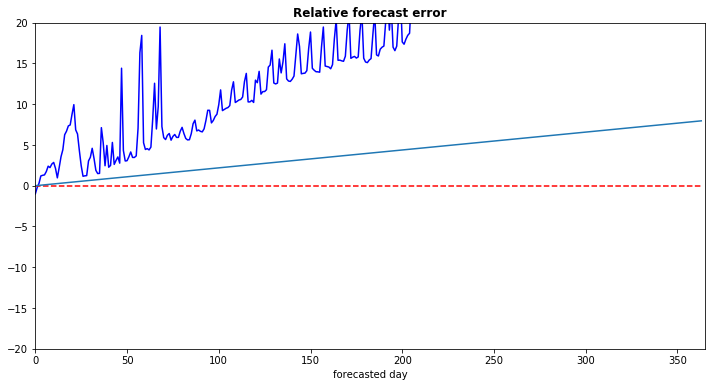

In [103]:
fig=plt.figure(figsize=(12,6))

plt.plot(range(n_pred),(x_predict[0,:]-consumption_day_ahead[:n_pred])/consumption_day_ahead[:n_pred],color='blue')
#plt.plot(range(n_pred),(x_predict[1,:]-consumption_day_ahead[1:n_pred+1])/consumption_day_ahead[1:n_pred+1],color='orange')
#plt.plot(range(n_pred),(x_predict[2,:]-consumption_day_ahead[2:n_pred+2])/consumption_day_ahead[2:n_pred+2],color='green')

plt.plot(range(n_pred-1),np.zeros(n_pred-1),color='red',linestyle='--')
plt.plot(range(n_pred-1),np.arange(n_pred-1)*8/365)
plt.ylim(-20,20)
plt.xlim(0,n_pred)
plt.xlabel('forecasted day')
plt.title("Relative forecast error",fontweight='bold')
plt.show()

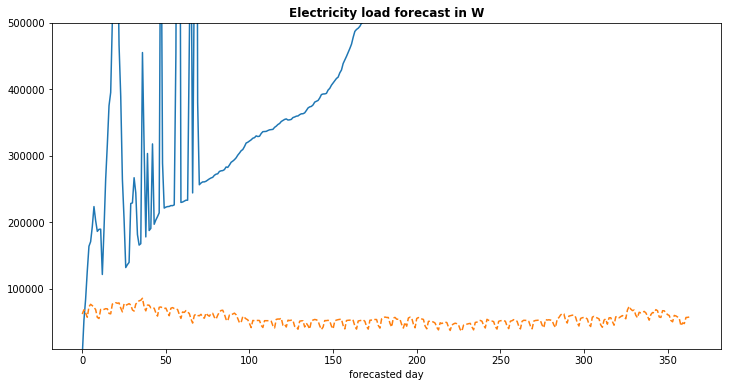

In [97]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(n_pred),x_predict[0,:])
#plt.plot(range(n_pred),x_predict[1,:])
#plt.plot(range(n_pred),x_predict[2,:])
plt.plot(range(n_pred),consumption_day_ahead[:n_pred],linestyle='--')
plt.xlabel('forecasted day')
plt.ylim(10**4,5*10**5)
plt.title("Electricity load forecast in W",fontweight='bold')
plt.show()

Goal: re-estimate the one-dimensional parameters ($\sigma_g,\sigma_s,\mu_h,\kappa,\sigma$)<br>
Proposal distribution for these parameters: truncated gaussian random walk<br>
We set kappa constant at 1/8



## PMMH

#### Initialization of parameters

In [ ]:
len_filter_pmmh = 365
len_iter_mha = 2

#### PMMH Algorithm

In [ ]:
start_time = time.time()
pf.pmmh(len_filter_pmmh, len_iter_mha, pred_forward, len_init)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
pf.sigma_g_list

In [ ]:
pf.sigma_s_list

In [ ]:
pf.sigma_list

In [ ]:
pf.u_h_list

In [ ]:
pf.accept_rate